#### Zip 

With zip one can loop over more than one list at a time:

In [17]:
g=[1,2,3,4]
h=[3,4,5,6]
j=[9,2,4,5]
for i in zip(g,h,j):
    print(i)

(1, 3, 9)
(2, 4, 2)
(3, 5, 4)
(4, 6, 5)


### Unpacking

Unpacking is a useful technique to obtain the elements of an array

In [18]:
v=([1,2],[3,4])
element1, element2 = v

print(element1)
print(element2)

[1, 2]
[3, 4]


[7.59e+04, 9.5e+04, 8.29e+04, 7.8e+04, ..., 2.23e+05, 7.93e+04, 9.38e+04]


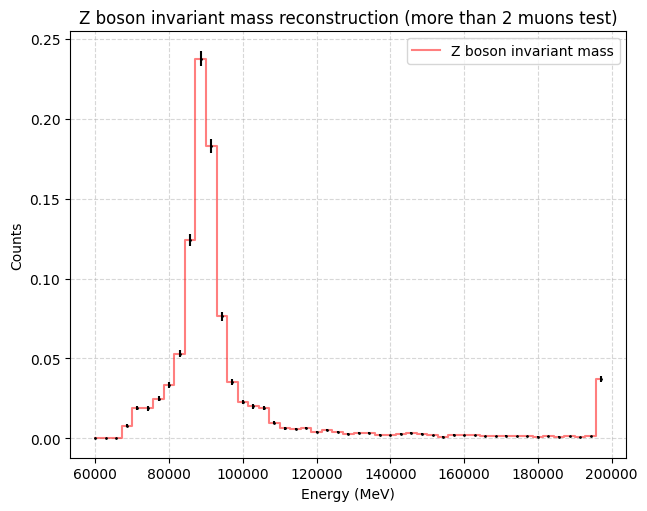

In [19]:
import my_functions
import uproot
import numpy as np #math and science package
import scipy as sp #math and science package
import awkward as ak #root files are usuallt awkward arrays 
import matplotlib.pyplot as plt #plot stuff
from my_functions import coolplot
from my_functions import ak_element_lenght_counter
from my_functions import plot_number_elements_per_event
from my_functions import quality_locator
from my_functions import quality_selector
from my_functions import ak_element_lenght_counter
from my_functions import invariant_mass_all_muons
from my_functions import invariant_mass
import itertools

def invariant_mass_all_muons(pt,eta,phi):
    #This function takes the entire set of data that contains information about the eta, phi and pt of the muons
    #and computes a list that contains the invariant mass associated to every event

    j=0

    invariant_masses=[]
    for i in range(len(eta)):
        if len(eta[i]) & len(phi[i]) & len(pt[i]) == 2:
            eta1=(eta[i])[0]
            eta2=(eta[i])[1]
            phi1=(phi[i])[0]
            phi2=(phi[i])[1]
            pt1=(pt[i])[0]
            pt2=(pt[i])[1]
            invariant_masses.append(invariant_mass(pt1, eta1, phi1, pt2, eta2, phi2))
            j=j+1
    return ak.Array(invariant_masses)

def invariant_mass(pt1, eta1, phi1, pt2, eta2, phi2):

    #This function calculates the invariant mass of the system. The first block is for muon 1 and the second for muon 2.
    #The third block adds up the contributions from muon 1 and 2. Finally, the invariant mass is computed.
    
    px1 = pt1 * np.cos(phi1)
    py1 = pt1 * np.sin(phi1)
    pz1 = pt1 * np.sinh(eta1)
    E1  = pt1 * np.cosh(eta1)

    px2 = pt2 * np.cos(phi2)
    py2 = pt2 * np.sin(phi2)
    pz2 = pt2 * np.sinh(eta2)
    E2  = pt2 * np.cosh(eta2)

    px = px1 + px2
    py = py1 + py2
    pz = pz1 + pz2
    E  = E1 + E2

    mass_squared = E**2 - (px**2 + py**2 + pz**2)
    return np.sqrt(mass_squared) if mass_squared > 0 else 0.0

def pair_selector(pt,eta,phi,i):

 #This function aims to select the "real" pair of muons when an event has more than two muons involved

 #Let's hardcode the theoretical value of a Z mass
 ztheo=911880 #MeV

 mu=[]
 res=[]
 diff=[]
 #First, check if the lenght of the different variables is the same for some [i] event. Otherwise ignore the event, since the data
 #is not consistent 
 if (len(eta[i]) == len(phi[i]) == len(pt[i]) and len(eta[i])>2): 
    for j in range(len(eta[i])):
        aux=[(pt[i])[j],(eta[i])[j],(phi[i])[j]] #for each muon collect mu=(pt,eta,phi)
        mu.append(aux)                           #and create a vector that contains the values (mu1,mu2,mu3,...,muN)
    pairs=list(itertools.combinations(mu,2))     #create list of all possible pairs
    for mu1, mu2 in pairs:
        #for every pair take the first mu and assign pt1,eta1,phi1
        pt1, eta1, phi1 = mu1
        pt2, eta2, phi2 = mu2
        #compute the invariant mass of the pair
        a=invariant_mass(pt1, eta1, phi1, pt2, eta2, phi2)
        res.append(a)
        #and also the difference with respect to the theoretical Z mass
        b=abs(ztheo-a)
        diff.append(b)
    #Now select the best pair (meaning: pair with the smallest differencie with respect to the theoretical value)
    best_pair_position=diff.index(min(diff)) #This is the position of the best pair 
    invariant_mass_best_pair=res[best_pair_position] #The invariant mass of the best pair
    best_pair=pairs[best_pair_position] #The vector [mu1,mu2] that contains the values of pt, eta and phi of the best pair
    
    return(invariant_mass_best_pair,best_pair)

def invariant_mass_all_muons2(pt,eta,phi):
    #This function takes the entire set of data that contains information about the eta, phi and pt of the muons
    #and computes a list that contains the invariant mass associated to every event

    invariant_masses=[]
    
    #Scan all events
    for i in range(len(eta)-10000,len(eta)):
        #If the event involves two muons
        if len(eta[i]) and len(phi[i]) and len(pt[i]) == 2:
            eta1=(eta[i])[0]
            eta2=(eta[i])[1]
            phi1=(phi[i])[0]
            phi2=(phi[i])[1]
            pt1=(pt[i])[0]
            pt2=(pt[i])[1]
            invariant_masses.append(invariant_mass(pt1, eta1, phi1, pt2, eta2, phi2))
        #If it involves more than 2 muons
        else:
            m = pair_selector(pt, eta, phi, i)
            if m is not None:  # Ensure that m is not None
                invariant_masses.append(m[0])
                
    return ak.Array(invariant_masses)

file= uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/Muon_trees.root") #opening the Root file with Uproot 

MuonTree_Zmumu=file["MuonTree_Zmumu;1"]

Zmumu_data=MuonTree_Zmumu["muon_e"].array()

MuonTree_Zmumu=file["MuonTree_Zmumu;1"] 

eta=MuonTree_Zmumu["muon_eta"].array()
phi=MuonTree_Zmumu["muon_phi"].array()
pt=MuonTree_Zmumu["muon_pt"].array()

Z_mass=invariant_mass_all_muons2(pt,eta,phi) #computes the invariant mass vector
print(Z_mass)

file= uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/Muon_trees.root") #opening the Root file with Uproot 

MuonTree_Zmumu=file["MuonTree_Zmumu;1"]

Zmumu_data=MuonTree_Zmumu["muon_e"].array()

MuonTree_Zmumu=file["MuonTree_Zmumu;1"] 

eta=MuonTree_Zmumu["muon_eta"].array()
phi=MuonTree_Zmumu["muon_phi"].array()
pt=MuonTree_Zmumu["muon_pt"].array()

Z_mass=invariant_mass_all_muons2(pt,eta,phi) #computes the invariant mass vector

data=[Z_mass]
bins=np.linspace(6*10**4,2*10**5)
colors=['r','b']
x_label=r"Energy (MeV)"
y_label="Counts"
title=r"Z boson invariant mass reconstruction (more than 2 muons test)"
label2='Z boson invariant mass'
labels=[label2]
coolplot(data,bins,colors,labels,x_label,y_label,title)
